<a href="https://colab.research.google.com/github/lifewinning/MLTSA22_IBurrington/blob/main/HW6/IB_HW6_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="red">FBB some mistakes here, see below - but you did really good in the exploration of the rupture usage!</font>

In [ ]:
!pip install ruptures
import ruptures as rpt
import pylab as pl
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Synthetic Data 

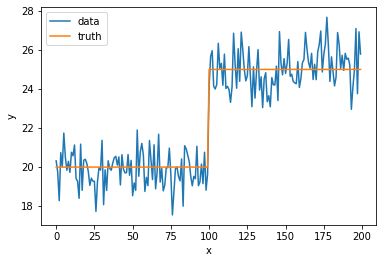

In [ ]:
mu1, mu2 = 20, 25
x = np.arange(200)
ym = np.concatenate([np.random.randn(100) + mu1, np.random.randn(100) + mu2])
pl.plot(x, ym, label="data") 
pl.plot(range(200), [mu1] * 100 + [mu2] * 100, label="truth")
pl.xlabel("x")
pl.ylabel("y")
pl.legend();

Fig. 1: plot of our synthetic dataset and its mean; both the data and the mean abruptly increase around point 100.

# Single POC -  difference of means

In [ ]:
def maxdiff(y):
    """calculates the POC as the points that maximized the difference between the mean before and the mean after the POC
    y: vector of endogenouos variables
    
    """
    N = len(y)
    f = np.nanmean
    poc, diff, before, after = 0, 0, np.nan, np.nan
    for i in range(1, N):
        diff_here = np.abs(f(ym[i:]) -  f(ym[:i]))
        if diff < diff_here:
            diff = diff_here
            poc = i
            before, after = f(ym[:i]), f(ym[i:])
    return(poc, before, after)  

print("poc: {:.2f}, mean before: {:.2f}, mean after: {:.2f}".format(*maxdiff(ym)))


poc: 100.00, mean before: 19.85, mean after: 25.04


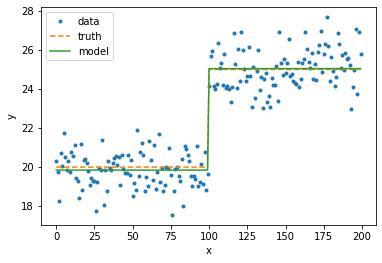

In [ ]:
poc, before, after = maxdiff(ym)   
pl.plot(x, ym, '.', label="data")
pl.plot(range(200), [mu1] * 100 + [mu2] * 100, '--', label="truth")
pl.plot(x, [before] * poc + [after] * (len(ym) - poc), label="model")
pl.xlabel('x')
pl.ylabel('y');
pl.legend();

Fig. 2: our synthetic dataset as a scatterplot, with line plots for the actual mean of the synthetic dataset and the mean as calculated by our model that calculated the difference in means to determine point of change.

# Single POC - MSE

In [ ]:

def poc_mse(y): 
  """calculates the POC fom the mean squared error""" 
  N = len(y) 
  f = np.nanmean 
  poc, diff, before, after = 0, 0, np.nan, np.nan 
  for i in range(1, N):
    diff_here = ((np.sum((y[:i])**2))/len(y[:i])) + (np.sum((y[i:] - y[i])**2)/len(y[:i]))/ N
    if diff < diff_here:
      # print(i, diff_here)
      diff = diff_here
      poc = i
      before, after = f(y[:i]), f(y[i:])
  return(poc, before, after)

print("poc: {:.2f}, mean before: {:.2f}, mean after: {:.2f}".format(*poc_mse(ym)))

poc: 199.00, mean before: 22.43, mean after: 25.79


In [ ]:
### FBB REVISION
def poc_mse(y): 
  """calculates the POC fom the mean squared error""" 
  N = len(y) 
  f = np.nanmean 
  #here i want to minimize the model error so start w diff = np.inf
  poc, diff, before, after = 0, np.inf, np.nan, np.nan 
  tmp_ = []
  for i in range(1, N):
    #model is the segment mean, MSE is sum of (model - data)**2
    diff_here = np.abs(np.sum((y[:i] - np.mean(y[:i]))**2) / len(y[:i]) - 
      np.sum((y[i:] - np.mean(y[i:]))**2) / len(y[i:]))#MSE
    tmp_.append(diff_here)
    #diff_here = ((np.sum((y[:i])**2))/len(y[:i])) + (np.sum((y[i:] - y[i])**2)/len(y[:i]))/ N
    if diff > diff_here:
      #print(i, diff_here)
      diff = diff_here
      poc = i
      before, after = f(y[:i]), f(y[i:])
  #pl.plot(tmp_)
  return(poc, before, after)


In [ ]:
poc, before, after = poc_mse(ym)   
before, poc

(19.889605847071298, 101)

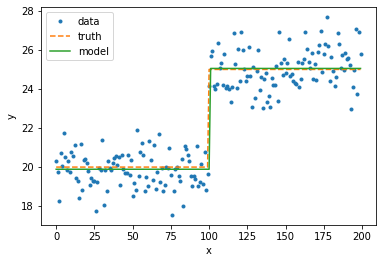

In [ ]:
pl.plot(x, ym, '.', label="data")
pl.plot(range(200), [mu1] * 100 + [mu2] * 100, '--', label="truth")
pl.plot(x, [before] * poc + [after] * (len(ym) - poc), label="model")
pl.xlabel('x')
pl.ylabel('y');
pl.legend();

Fig. 3: our synthetic dataset as a scatterplot, with line plots for the actual mean of the synthetic dataset and the mean as calculated by our model that calculating difference in mean squared error. I am pretty sure I did this wrong; when running this a few times with `print(i, diff_here)` uncommented I noticed that numbers in the 100-101 tended to make it into the loop, but it seems to overshoot? 

<font color="red"> FBB, yeah, look at the revised code </font>




# Single POC - diff of variance


In [ ]:
mu1 =  20
s2 = 4
ys = np.concatenate([np.random.randn(100)  + mu1 , np.random.randn(100) * s2 + mu1])

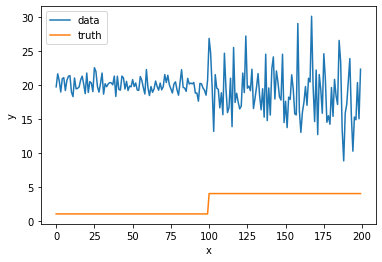

In [ ]:
pl.plot(x, ys, label="data") 
pl.plot(range(200), [1] * 100  + [s2] * 100, label="truth")
pl.xlabel("x")
pl.ylabel("y")
pl.legend();

Fig. 4: a plot of our new synthetic dataset and its standard deviation.

<font color="red"> FBB, yok </font>

In [ ]:
def maxdiff(y, sigma=False):
    """calculates the POC as the points that maximized the difference between 
                the mean or variance before and the mean after the POC
    y: vector of endogenouos variables 
    sigma: finds the POC that maximizes the difference between before/after POC variance 
                (optional, default is before/after mean)"""
    N = len(y)
    # this took me way too long to figure out bc I didn't notice that the original maxdiff had "f(ym[i:])" instead of "f(y[i:])" lol
    if sigma !=True:
      f = np.nanmean
    else:
      f = np.nanstd
    poc, diff, before, after = 0, 0, np.nan, np.nan
    for i in range(1, N):
        diff_here = np.abs(f(y[i:]) -  f(y[:i]))
        if diff < diff_here:
            diff = diff_here
            poc = i
            before, after = f(y[:i]), f(y[i:])
    return(poc, before, after)  
print("poc: {:.2f}, standard deviation before: {:.2f}, standard deviation after: {:.2f}".format(*maxdiff(ys, sigma=True)))


poc: 1.00, standard deviation before: 0.00, standard deviation after: 2.92


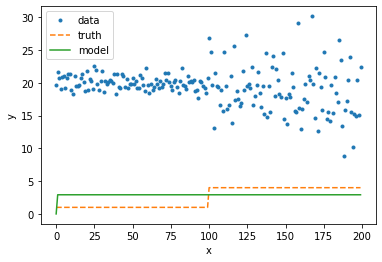

In [ ]:
poc, before, after = maxdiff(ys, sigma=True)   
pl.plot(x, ys, '.', label="data")
pl.plot(range(200), [1] * 100  + [s2] * 100,'--', label="truth")
pl.plot(x, [before] * poc + [after] * (len(ys) - poc), label="model")
pl.xlabel('x')
pl.ylabel('y');
pl.legend();

Fig. 5: scatter plot of our synthetic data with line plot of our model identifying difference in standard deviations. The "true" standard deviation plot is also there but might be hard to see because the model gets pretty close.

# Using rupture to find POC in synthetic data

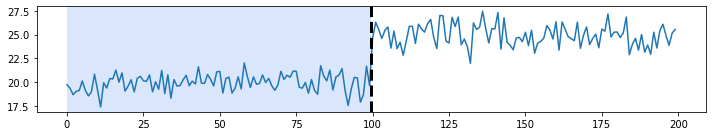

In [ ]:
# detection
algo = rpt.Pelt(model="l2").fit(ym)
result = algo.predict(pen=10)

# display
rpt.display(ym, [100], result)
pl.show()

Fig. 6: using the Pelt method to identify the point of change in our first synthetic dataset where change was in the mean. Light blue background demarcates point before POC, white background demarcates point after, with a dashed black line dividing the two. I tried other penalty numbers and this seemed to be the one that actually got our one point of change instead of a bunch of them?

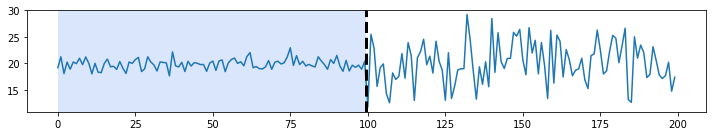

In [ ]:
# detection
# OK I was literally just guessing here
algo = rpt.Pelt(model="rbf").fit(ys)
result = algo.predict(pen=10)

# display
rpt.display(ys, [100], result)
pl.show()

Fig. 7: using the Pelt method to identify the point of change in our synthetic data where the change was in standard deviation instead of mean. Light blue background demarcates point before POC, white background demarcates point after, with a dashed black line dividing the two. I only kind of understand why this worked. 

# Load and describe LANL data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/MLTSA22

/content/drive/MyDrive/MLTSA22


In [ ]:
# skip if already downloaded!
!wget http://fbb.space/mltsa/LALNeq.csv

--2022-04-04 23:26:02--  http://fbb.space/mltsa/LALNeq.csv
Resolving fbb.space (fbb.space)... 107.180.39.232
Connecting to fbb.space (fbb.space)|107.180.39.232|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113902284 (109M) [text/csv]
Saving to: ‘LALNeq.csv.4’

LALNeq.csv.4        100%[===================>] 108.62M  16.3MB/s    in 11s     

2022-04-04 23:26:13 (10.2 MB/s) - ‘LALNeq.csv.4’ saved [113902284/113902284]



In [ ]:
eq1 = pd.read_csv('LALNeq.csv').drop(labels='Unnamed: 0', axis = 1)
eq1.describe()

,acoustic_data,time_to_failure
count,4.500000e+06,4.500000e+06
mean,4.616407e+00,8.852012e-01
std,2.614006e+01,3.374432e-01
min,-4.621000e+03,3.008971e-01
25%,2.000000e+00,5.934956e-01
50%,5.000000e+00,8.849986e-01
75%,7.000000e+00,1.177597e+00
max,3.252000e+03,1.469100e+00


In [ ]:
eq1.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [ ]:
eq1.tail()

,acoustic_data,time_to_failure
4499995,4,0.300897
4499996,6,0.300897
4499997,1,0.300897
4499998,3,0.300897
4499999,4,0.300897


In [ ]:
eq1.shape

(4500000, 2)

Text(0, 0.5, 'Acoustic Data')

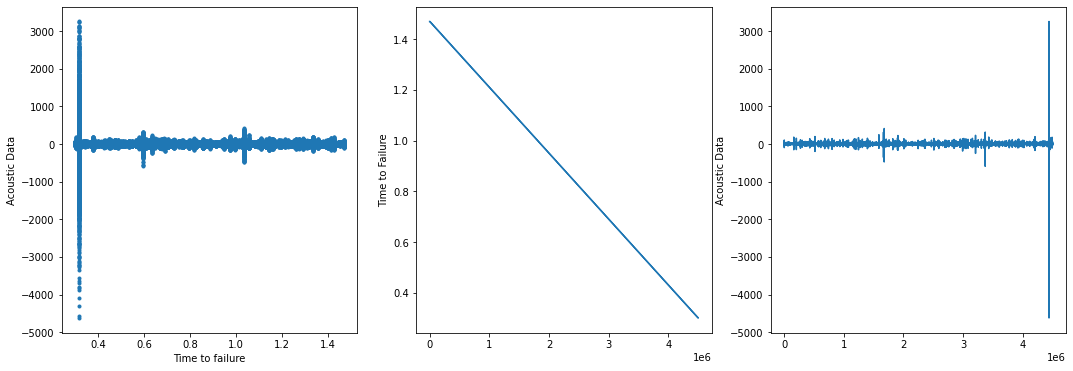

In [ ]:
fig, ax = pl.subplots(1,3, figsize=(18, 6))
ax[0].plot(eq1['time_to_failure'], eq1['acoustic_data'], '.')
ax[0].set_xlabel('Time to failure')
ax[0].set_ylabel('Acoustic Data')
ax[1].plot(np.arange(0, eq1.shape[0]), eq1['time_to_failure'])
ax[1].set_ylabel('Time to Failure')
ax[2].plot(np.arange(0, eq1.shape[0]), eq1['acoustic_data'])
ax[2].set_ylabel('Acoustic Data')

Fig. 8: visualizations of the LANL data. On left, plotting time to failure against acoustic data (apparently there's more variability in the lower times to failure); center is time to failure as the y-axis (which has a very clear downward trend over time); on right is acoustic data on the y-axis (which has a fairly consistent mean but some variance in spots and significant variance toward the end of the dataset). 

# Dynamic Programming exploration

Look at the "cost functions" and "search methos" tab here - https://centre-borelli.github.io/ruptures-docs/user-guide/ and the paper https://arxiv.org/pdf/1801.00718.pdf to find the computational cost associate to each method.





change points: [4840, 10000]


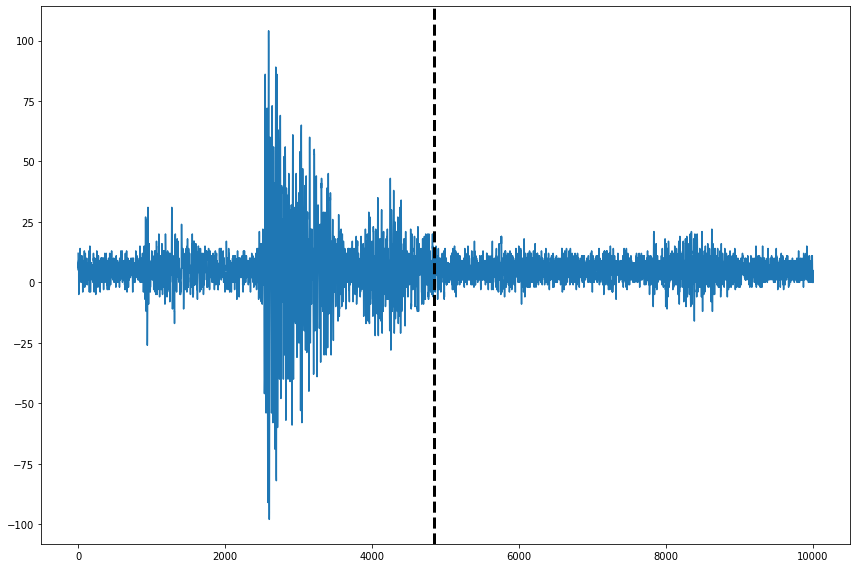

In [ ]:
# once again, I have no idea why this worked but it produced a plot that looked like Fed's plot! Also it's pretty slow.   
dnyp1 = rpt.Dynp(model="rbf").fit(eq1.acoustic_data.values[:10000])
result = dnyp1.predict(n_bkps=1)
print('change points: {0}'.format(result))
# display
rpt.display(eq1.acoustic_data.values[:10000], [], result, figsize = (12,8))
plt.show()


Fig. 9: plot of the first 10,000 acoustic data values from Los Alamos National Laboratory earthquake data with a point of change selected using the dynamic programming method in `ruptures`. The model/costing method chosen was `rbf` but if I'm being completely honest I picked that one because it produced a result closest to what Fed had already generated and it was pretty fast? I know it's better than L1.

<font color="red"> FBB the model finds a point in the center - that generally means it failed to find a single meaningful point and defaults to the middle of the time series</font>

change points: 2595


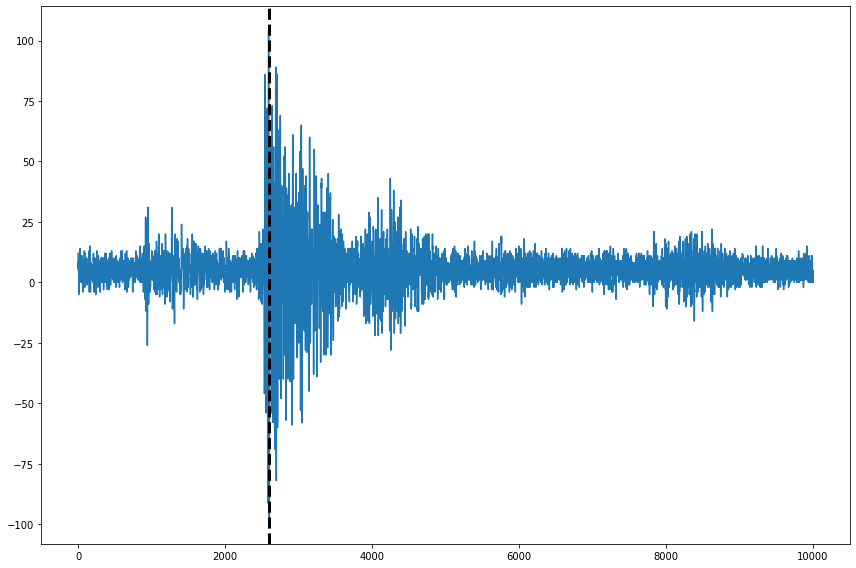

In [ ]:
algo1 = rpt.Dynp(model="l2").fit(eq1.acoustic_data.values[:10000])
result = algo1.predict(n_bkps=1)
print('change points: {0}'.format(result[0]))
# display
rpt.display(eq1.acoustic_data.values[:10000], [], result, figsize = (12,8))
plt.show()

Fig. 10: The same 10,000 LANL data points from Fig. 9, but now identifying point of change using the L2 costing method with dynamic programming. Using L2 seems to have made a more abrupt/dramatic change point the one selected by the method over the one selected in Fig. 7--I assume this is because L2 is looking for changes in the mean and RBF is doing something more complicated?

<font color="red"> FBB good!</font>

/usr/local/lib/python3.7/dist-packages/ruptures/costs/costnormal.py:32: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  UserWarning,


change points: 4640


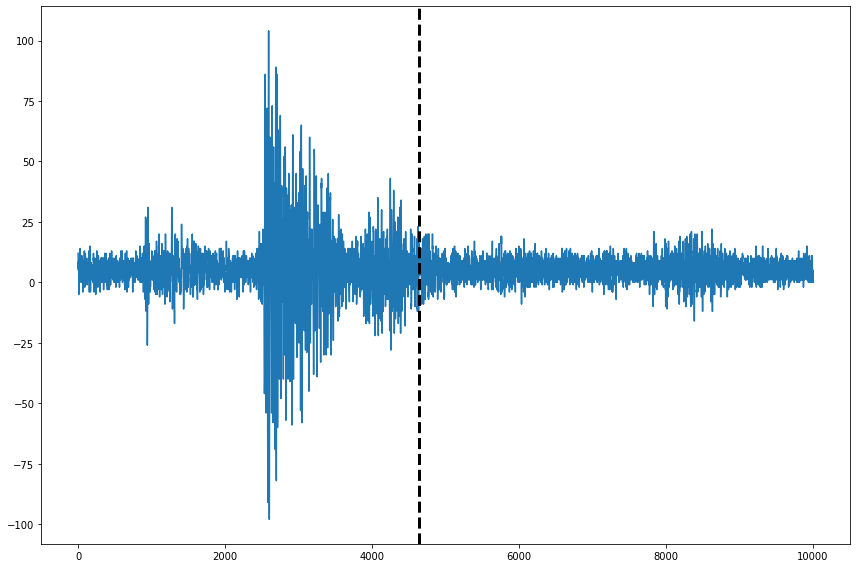

In [ ]:
algo1 = rpt.Dynp(model="normal").fit(eq1.acoustic_data.values[:10000])
result = algo1.predict(n_bkps=1)
print('change points: {0}'.format(result[0]))
# display
rpt.display(eq1.acoustic_data.values[:10000], [], result, figsize = (12,8))
plt.show()

Fig. 11: The same 10,000 LANL data points from Fig. 9, but now identifying point of change using the normal costing method with dynamic programming. This is definitely a lot closer to the `rbf` result, and certainly faster so maybe that's the one I should go with? 

<font color="red"> FBB I think the best result is the L2: there is a definite PoC there - you found your earthquake start in that model!</font>

/usr/local/lib/python3.7/dist-packages/ruptures/costs/costnormal.py:32: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  UserWarning,


change points: [2530, 3445, 5000]


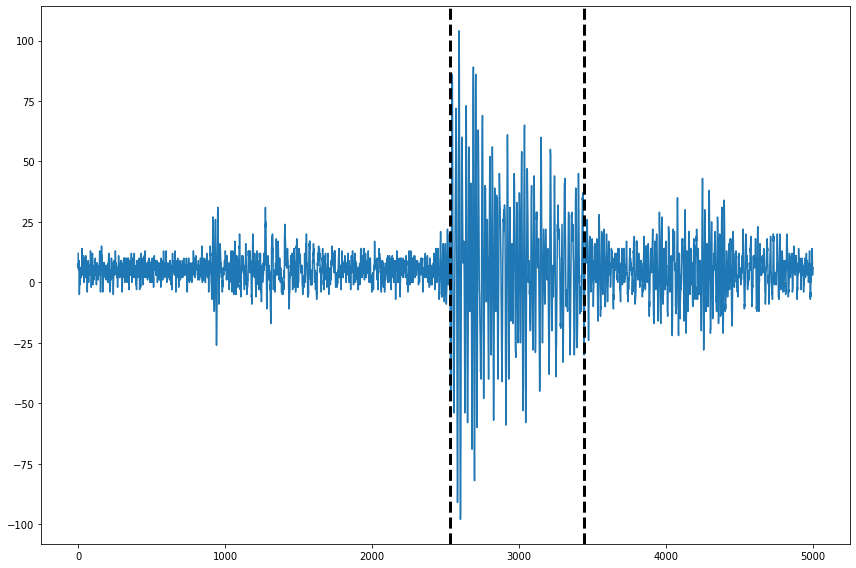

In [ ]:
algo2 = rpt.Dynp(model="normal").fit(eq1.acoustic_data.values[:5000])
result = algo2.predict(n_bkps=2)
print('change points: {0}'.format(result))
# display
rpt.display(eq1.acoustic_data.values[:5000], [], result, figsize = (12,8))
plt.show()

Fig. 12: The first 5,000 LANL acoustic data points with 2 points of change marked. POCs were derived using dynamic programming method and normal cost function (chosen based on trying different cost functions for `algo1`). Comparing the means and standard deviations of the data points before and after the points of change, it seems like the variance is more significant than the mean change; reading the documentation I think `normal` accounts for variance unlike L1 and L2?

<font color="red"> FBB ok</font>

In [ ]:
np.std(eq1.acoustic_data.values[:2605]), np.std(eq1.acoustic_data.values[2605:3640]), np.std(eq1.acoustic_data.values[3640:5000])

(10.847213202211018, 26.631873331943098, 9.764206999126928)

In [ ]:
np.mean(eq1.acoustic_data.values[:2605]), np.mean(eq1.acoustic_data.values[2605:3640]), np.mean(eq1.acoustic_data.values[3640:5000])

(5.104414587332053, 5.58840579710145, 4.9338235294117645)

/usr/local/lib/python3.7/dist-packages/ruptures/costs/costnormal.py:32: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  UserWarning,


change points: [895, 905, 970, 1000]


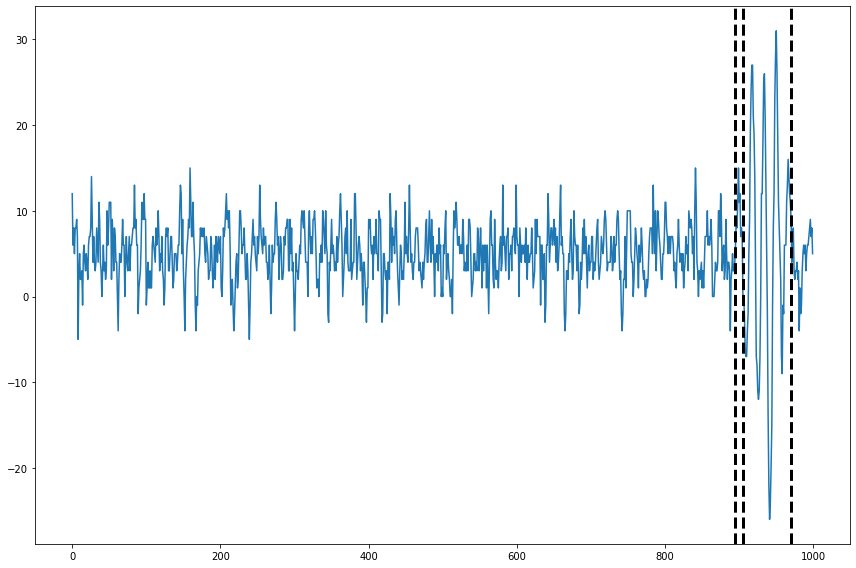

In [ ]:
algo3 = rpt.Dynp(model="normal").fit(eq1.acoustic_data.values[:1000])
result = algo3.predict(n_bkps=3)
print('change points: {0}'.format(result))
# display
rpt.display(eq1.acoustic_data.values[:1000], [], result, figsize=(12,8))
plt.show()

Fig. 13: the first 1,000 points in the LANL acoustic data, with points of change derived from dynamic programming using the normal cost function, based on how it performed in the previous figures.

In [ ]:
np.mean(eq1.acoustic_data.values[:895]), np.mean(eq1.acoustic_data.values[895:970])

(5.106145251396648, 5.8133333333333335)

In [ ]:
np.std(eq1.acoustic_data.values[:895]), np.std(eq1.acoustic_data.values[895:970])

(3.2302543617294077, 13.031953891194606)

# Running Bottom-up and Dynamic Programming

In [ ]:
tenk = rpt.Dynp(model="normal").fit(eq1.acoustic_data.values[:10000])
tenk_result = tenk.predict(n_bkps=3)
tenk_result

/usr/local/lib/python3.7/dist-packages/ruptures/costs/costnormal.py:32: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  UserWarning,


[2530, 3445, 4840, 10000]

In [ ]:
algo = rpt.BottomUp(model='normal').fit(eq1.acoustic_data.values[:10000])
result = algo.predict(n_bkps=3)
result

/usr/local/lib/python3.7/dist-packages/ruptures/costs/costnormal.py:32: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  UserWarning,


[2530, 3445, 4835, 10000]

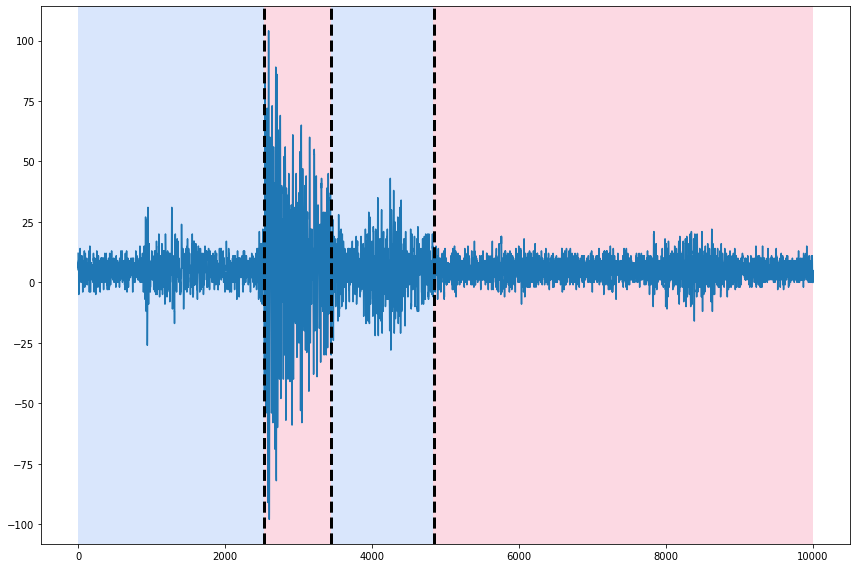

In [ ]:
rpt.display(eq1.acoustic_data.values[:10000], result, tenk_result, figsize=(12, 8))
plt.show()

Fig. 14: The first 10,000 LANL acoustic data points with 2 points of change methods implemented. Alternating color sections indicate points of change derived from a bottom-up method, dashed lines indicate points of change derived from dynamic programming. Once again, I returned to the `normal` cost function because it seemed to do well with the previous figures, but it also produced nearly identical results from the two methods? I tried a few different `min_size` parameters and methods on the dynamic programming method just to see if it produced more interesting outcomes but I don't actually know if those results were necessarily better or more precise.

<font color="red"> FBB you did very good on the rupture part - you explored the functionality and got familiar with how your choices impact the results</font>